In [1]:
import numpy as np
import pandas as pd
import random
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn import preprocessing
import matplotlib.pyplot as plt
import time
import seaborn as sns
from sklearn.externals import joblib

/home/veruska/.local/lib/python3.6/site-packages/sklearn/externals/joblib/__init__.py:15: DeprecationWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=DeprecationWarning)


In [2]:
file_path = '../../data/input/integrated_data_dummy.csv'

data = pd.read_csv(file_path)
data = data.sort_values(["busCode","busCodeSB"])

In [3]:
# FILTERING HIGHER HEADWAYS (2% of the data)
two_hours = 120
data = data[data.headway <= two_hours]

In [3]:
data.isnull().any()

route                                      False
tripNum                                    False
shapeSequence                              False
shapeLat                                   False
shapeLon                                   False
                                           ...  
alertTypeSB_ROAD_CLOSED                    False
jamBlockTypeSB_-                           False
jamBlockTypeSB_NORMAL                      False
jamBlockTypeSB_ROAD_CLOSED_CONSTRUCTION    False
jamBlockTypeSB_ROAD_CLOSED_EVENT           False
Length: 419, dtype: bool

In [4]:
# Get label column and remove it from data
y = data['headway']
data.drop('headway', axis=1, inplace=True)
data.drop('busBunching', axis=1, inplace=True)

In [5]:
# Normalize data
min_max_scaler = preprocessing.MinMaxScaler()
data_scale = min_max_scaler.fit_transform(data)

In [6]:
# Making training and test data: 80% Training, 20% Test
random.seed(15) #to get always the same set
train_X, test_X, train_Y, test_Y = train_test_split(data_scale, y, test_size=0.20, random_state=7)

In [7]:
def rmse_cv(model, X_train, y_train):
    rmse = np.sqrt(-cross_val_score(model, X_train, y_train, scoring = "neg_mean_squared_error", cv = 5))
    return(rmse)

# function to plot the RMSE vs parameter value
def plot_rmse_param(series, param_name):
    series.plot(title = "Validation Error vs " + param_name)
    plt.xlabel(param_name)
    plt.ylabel("RMSE")
    
# function to get the best RMSE and the best parameter value of the model
def best_rmse_param(series):
    best_rmse = series.min()
    best_param = series.idxmin() 
    
    return(best_rmse, best_param)

In [8]:
del data
del y

### Random Forest

A random forest is a meta estimator that fits a number of classifying decision trees on various sub-samples of the dataset and uses averaging to improve the predictive accuracy and control over-fitting.

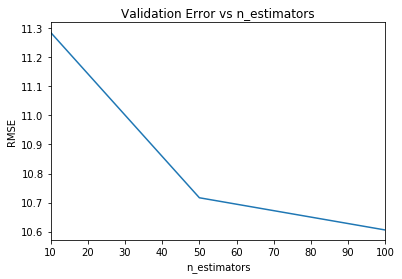

In [12]:
start = time.time()

n_estimators = [10, 50, 100] #number of trees
cv_rf_rmse = [rmse_cv(RandomForestRegressor(n_estimators = n, n_jobs=8), train_X, train_Y).mean() 
            for n in n_estimators]

series = pd.Series(cv_rf_rmse, index = n_estimators)
plot_rmse_param(series, "n_estimators")
best_rmse_rf, best_estimator_rf = best_rmse_param(series)

/home/veruska/.local/lib/python3.6/site-packages/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning
/home/veruska/.local/lib/python3.6/site-packages/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning
/home/veruska/.local/lib/python3.6/site-packages/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning
/home/veruska/.local/lib/python3.6/site-packages/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs 

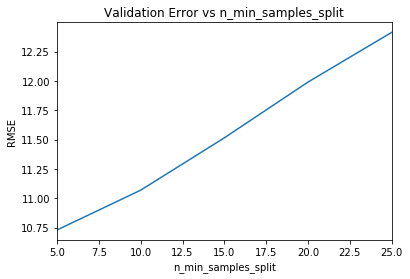

In [13]:
n_min_samples_split = [5, 10, 15, 20, 25]
cv_rf_rmse = [rmse_cv(RandomForestRegressor(n_estimators = best_estimator_rf, min_samples_split = n, n_jobs=8), 
                      train_X, train_Y).mean() 
            for n in n_min_samples_split]

series = pd.Series(cv_rf_rmse, index = n_min_samples_split)
plot_rmse_param(series, "n_min_samples_split")
best_rmse_rf, best_split_rf = best_rmse_param(series)

/home/veruska/.local/lib/python3.6/site-packages/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning
/home/veruska/.local/lib/python3.6/site-packages/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning
/home/veruska/.local/lib/python3.6/site-packages/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning
/home/veruska/.local/lib/python3.6/site-packages/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs 

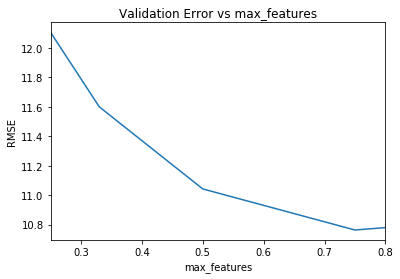

In [14]:
n_features = [0.25, 0.33, 0.5, 0.75, 0.8]
cv_rf_rmse = [rmse_cv(RandomForestRegressor(n_estimators=best_estimator_rf, min_samples_split=best_split_rf,
                                            max_features=n, n_jobs=8), 
                      train_X, train_Y).mean() 
            for n in n_features]

series = pd.Series(cv_rf_rmse, index = n_features)
plot_rmse_param(series, "max_features")
best_rmse_rf, best_max_feat_rf = best_rmse_param(series)

In [9]:
best_estimator_rf = 100
best_split_rf = 5
best_max_feat_rf = 0.75

In [10]:
random.seed(42)
rf = RandomForestRegressor(n_estimators=best_estimator_rf, min_samples_split=best_split_rf,
                           max_features=best_max_feat_rf, n_jobs=8)
rf.fit(train_X, train_Y)

# Saving a pickle file for the model
joblib.dump(rf, 'Saved_RF_100_5_075.pkl')

end = time.time()
print("Execution time: " + str((end - start)/60) + " min")

NameError: name 'start' is not defined

R2 coefficient (score) of determination is a statistical measure of how well the regression predictions approximate the real data points. The best one is 1.

In [11]:
# Testing
# rf_load = joblib.load('Saved_RF_100_5_08.pkl') 
# print(assert rf.score(test_X, test_Y) == ann_load.score(test_X, test_Y))

r2 = rf.score(test_X, test_Y)
r2

0.9279675571470478

In [32]:
print(str(r2) + " of the data is been explained by the model.")

0.9911614520012003 of the data is been explained by the model (overfitting).


In [18]:
print("best_estimator_rf: " + str(best_estimator_rf))
print("best_split_rf: " + str(best_split_rf))
print("best_max_features_rf: " + str(best_max_feat_rf))

best_estimator_rf: 100
best_split_rf: 5
best_max_features_rf: 0.75


In [12]:
pred = rf.predict(test_X)
rmse_rf = np.sqrt(mean_squared_error(test_Y,pred))
print(rmse_rf)

5.984649783581182


In [17]:
print(min(pred))
print(max(pred))

0.0
119.97121428571428


### Evaluating model

In [11]:
width = 5
height = 5

(-600, 600)

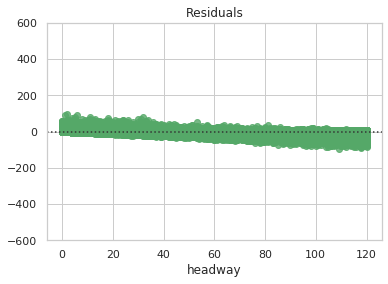

In [13]:
sns.set(style="whitegrid")

# Plot the residuals after fitting a linear model
ax = sns.residplot(test_Y, pred, color="g")
ax.set_title('Residuals')
ax.set_ylim([-600, 600])


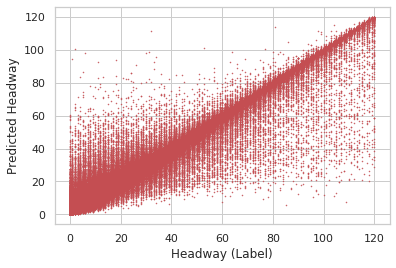

In [14]:
# Print all error to see if there is standard or some big outliers
plt.figure()
plt.plot(test_Y, pred, 'ro', ms=0.5)
# plt.ylim(10, 40)
plt.xlabel('Headway (Label)')
plt.ylabel('Predicted Headway')
plt.show()

NameError: name 'width' is not defined

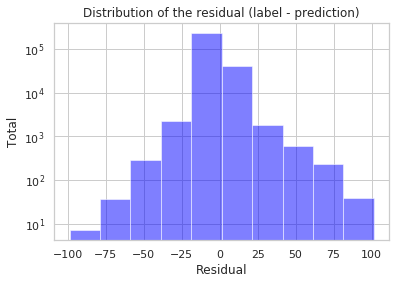

In [16]:
diff = test_Y - np.array(pred).flatten()
num_bins = 10
plt.hist(diff, num_bins, facecolor='blue', alpha=0.5, log=True)
plt.xlabel('Residual')
plt.ylabel('Total')
plt.title('Distribution of the residual (label - prediction)')
plt.rcParams["figure.figsize"] = (width,height) 
plt.show()

In [22]:
# Features importance

#create dictionary
f_imps = {}
for i in range(num_features):
    f_imps[features[i]] = rf.feature_importances_[i]
    
#sort dictionary 
sorted_feature_names = sorted(f_imps, key=f_imps.__getitem__, reverse=True)
sorted_values = sorted(f_imps.values(), reverse=True)

num_to_print = 20
for i in range(num_to_print):
    print("%15s %4.3f" % (sorted_feature_names[i], sorted_values[i]))

NameError: name 'num_features' is not defined